In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import shapely
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")

In [2]:
import dill
def dump_session(name):
    dill.dump_session(f'checkpoint_{name}.db')

## Import dataset from 01/01/2001 to 11/30/2019

In [2]:
raw_data = pd.read_csv("datasets/Crimes_-_2001_to_Present_20230927.csv")

In [4]:
data = raw_data.copy()

# ID, date, crime primary type, description of the crime, location, year, zip code
data = data[['ID', 'Date', 'Primary Type', 'Description', 'Year', 'District', 'Zip Codes', 'Longitude', 'Latitude']]

Here, the paper reported 35 type of crime but the dataset show 36. At a closer look, criminal sexual assault is repeated CRIMINAL SEXUAL ASSAULT and CRIM SEXUAL ASSAULT

In [5]:
# Fix typo
data['Primary Type'] = data['Primary Type'].replace(['CRIMINAL SEXUAL ASSAULT'], 'CRIM SEXUAL ASSAULT')

Description column also have alot of inconsistent values. For consistency, I have exported the data and clean it by excel

In [6]:
description_map = pd.read_csv("description_map.csv")
newmap = {}
for k, v in description_map.values:
    if type(v) != float:
        newmap[k] = v
        
data['Description'] = data['Description'].apply(lambda x: newmap.get(x, x))

In [19]:
def score_result(trueY, predY):
    print("accuracy: ", accuracy_score(trueY, predY))
    print("precision: ", precision_score(trueY, predY, average='macro'))
    print("recall: ", recall_score(trueY, predY, average='macro'))    
    print("f1: ", f1_score(trueY, predY, average='macro')) 
    print("classification report:\n", classification_report(trueY, predY))       

## EDA

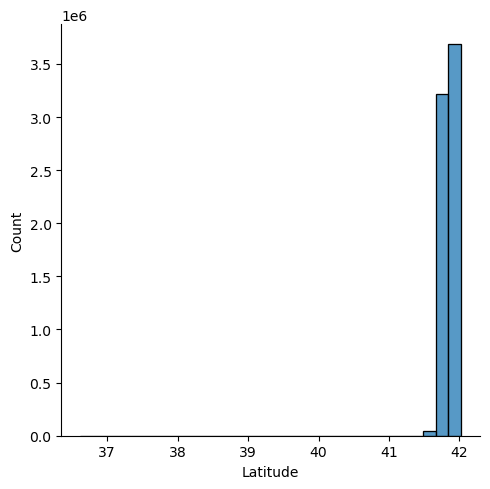

In [8]:
sns.displot(x="Latitude", data=data, bins=30)

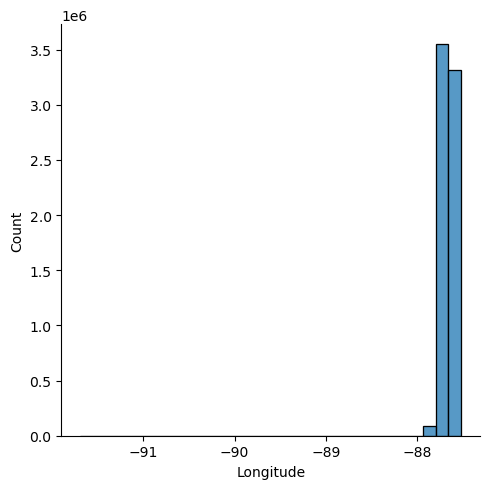

In [9]:
sns.displot(x="Longitude", data=data, bins=30)

In [ ]:
# do some pearson corr

In [ ]:
# do some kde graph

In [ ]:
# do something

## Pre-processing

In [253]:
data = raw_data.copy()

# ID, date, crime primary type, description of the crime, location, year, zip code
data = data[['ID', 'Date', 'Primary Type', 'Description', 'Year', 'District', 'Zip Codes', 'Longitude', 'Latitude']]

In [254]:
# Drop any null 
data = data.dropna()

In [255]:
# Parse date col
data['Date'] = pd.to_datetime(data['Date'], format="%m/%d/%Y %H:%M:%S %p")
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['AM/PM'] = data['Date'].dt.strftime('%p')
data['Second_since_morning'] = \
    (data['Date'].dt.hour + ((data['AM/PM'] == 'PM') * 12)) * 3600 + data['Date'].dt.minute * 60 + data['Date'].dt.second

In [256]:
# remove outliers
data.drop(data[data['Longitude'] < -90].index, inplace = True)

In [257]:
# Label encode description col
data['Description'] = LabelEncoder().fit_transform(data['Description'])

In [258]:
# train test split
X = data.drop('Primary Type', axis=1)
Y = data['Primary Type']

trainX, testX, trainY, testY = train_test_split(X, Y, train_size=0.7)
trainX = pd.DataFrame(trainX, columns=X.columns)
testX = pd.DataFrame(testX, columns=X.columns)

In [259]:
# Discretize
kbins = KBinsDiscretizer(n_bins=20, encode='ordinal')
trainX[['Second_since_morning']] = kbins.fit_transform(trainX[['Second_since_morning']])
testX[['Second_since_morning']] = kbins.transform(testX[['Second_since_morning']])

In [260]:
# Frequency encode
zip_freq = trainX['Zip Codes'].value_counts() / len(trainX['Zip Codes'])
category_frequency_map = zip_freq.to_dict()
trainX['Zip Freq'] = trainX['Zip Codes'].map(category_frequency_map)
testX['Zip Freq'] = testX['Zip Codes'].map(category_frequency_map)

In [261]:
trainX.drop(columns=['ID', 'Date', 'AM/PM'], inplace=True)
testX.drop(columns=['ID', 'Date', 'AM/PM'], inplace=True)

In [262]:
trainXcols = trainX.columns

In [263]:
ss = StandardScaler()
trainX = ss.fit_transform(trainX)
testX = ss.transform(testX)

In [264]:
over = SMOTE(sampling_strategy=
            (trainY.value_counts()[(5 < trainY.value_counts()) & (trainY.value_counts() < 100)] * 100).to_dict()
        )
trainX, trainY = over.fit_resample(trainX, trainY)

## Question 1

### Logistic Regression

In [287]:
lorCV = LogisticRegressionCV(Cs=5, max_iter=500, cv=3, n_jobs=-1)

In [288]:
lorCV.fit(trainX, trainY)

predY_lor = lorCV.predict(testX)

score_result(testY, predY_lor)

accuracy:  0.35549394813343255
precision:  0.04081086776898727
recall:  0.06489280945968051
f1:  0.0477315100025507
classification report:
                                    precision    recall  f1-score   support

                            ARSON       0.00      0.00      0.00      3422
                          ASSAULT       0.00      0.00      0.00    131305
                          BATTERY       0.25      0.34      0.29    382650
                         BURGLARY       0.00      0.00      0.00    119051
CONCEALED CARRY LICENSE VIOLATION       0.00      0.00      0.00       130
              CRIM SEXUAL ASSAULT       0.00      0.00      0.00      7861
                  CRIMINAL DAMAGE       0.41      0.96      0.57    238556
          CRIMINAL SEXUAL ASSAULT       0.00      0.00      0.00       433
                CRIMINAL TRESPASS       0.00      0.00      0.00     60158
               DECEPTIVE PRACTICE       0.00      0.00      0.00     81499
                DOMESTIC VIOLENCE 

In [300]:
lorCV.C_

array([10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000.])

In [ ]:
dump_session("logreg")

### Random Forest

In [24]:
grid_rf = {
    "n_estimators": np.arange(10, 50, 10),
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, "balanced", "balanced_subsample"]
}

dtc = RandomForestClassifier()
gs_rf = RandomizedSearchCV(dtc, grid_rf, cv=3, n_jobs=-1, verbose=3, refit=True, n_iter=20)

gs_rf.fit(trainX, trainY)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 3/3] END class_weight=balanced, criterion=entropy, max_depth=None, min_samples_leaf=2, n_estimators=40;, score=0.909 total time=28.1min
[CV 3/3] END class_weight=balanced_subsample, criterion=gini, max_depth=None, min_samples_leaf=4, n_estimators=40;, score=0.885 total time=22.6min
[CV 1/3] END class_weight=balanced_subsample, criterion=gini, max_depth=10, min_samples_leaf=4, n_estimators=30;, score=0.353 total time= 8.3min
[CV 3/3] END class_weight=balanced_subsample, criterion=gini, max_depth=10, min_samples_leaf=4, n_estimators=30;, score=0.379 total time= 8.2min
[CV 2/3] END class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=2, n_estimators=40;, score=0.358 total time=11.0min
[CV 2/3] END class_weight=None, criterion=gini, max_depth=10, min_samples_leaf=4, n_estimators=40;, score=0.631 total time= 9.4min
[CV 1/3] END class_weight=balanced, criterion=gini, max_depth=None, min_samples_leaf=4, n_estima

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'n_estimators': array([10, 20, 30, 40])},
                   verbose=3)

In [25]:
predY_rf = gs_rf.predict(testX)

In [31]:
gs_rf.best_params_

{'n_estimators': 40,
 'min_samples_leaf': 1,
 'max_depth': None,
 'criterion': 'entropy',
 'class_weight': 'balanced_subsample'}

In [26]:
score_result(testY, predY_rf)

accuracy:  0.9158520169053408
precision:  0.8848282965333693
recall:  0.6769754215564837
f1:  0.7373100680210729
classification report:
                                    precision    recall  f1-score   support

                            ARSON       0.97      0.68      0.80      3411
                          ASSAULT       0.49      0.30      0.37    131242
                          BATTERY       0.78      0.90      0.83    384261
                         BURGLARY       0.99      0.99      0.99    118915
CONCEALED CARRY LICENSE VIOLATION       0.90      0.50      0.64       155
              CRIM SEXUAL ASSAULT       0.94      0.65      0.77      7800
                  CRIMINAL DAMAGE       0.96      1.00      0.98    238588
          CRIMINAL SEXUAL ASSAULT       0.52      0.11      0.19       434
                CRIMINAL TRESPASS       1.00      0.86      0.92     59492
               DECEPTIVE PRACTICE       0.96      0.96      0.96     81603
                DOMESTIC VIOLENCE    

In [27]:
dump_session("ranfor")

### KNN

In [295]:
grid_knn = {
    'n_neighbors': np.arange(2, 10),
    'metric': ['minkowski', 'cityblock', 'manhattan']
}

knn = KNeighborsClassifier()
gs_knn = RandomizedSearchCV(knn, grid_knn, cv=3, n_jobs=-1, verbose=3, refit=True)

gs_knn.fit(trainX, trainY)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 3/3] END ...metric=cityblock, n_neighbors=3;, score=0.454 total time=33.7min
[CV 3/3] END ...metric=minkowski, n_neighbors=2;, score=0.368 total time=15.2min
[CV 3/3] END ...metric=minkowski, n_neighbors=4;, score=0.418 total time=20.1min
[CV 3/3] END ...metric=manhattan, n_neighbors=3;, score=0.454 total time=33.7min
[CV 1/3] END ...metric=cityblock, n_neighbors=3;, score=0.453 total time=33.9min
[CV 1/3] END ...metric=minkowski, n_neighbors=8;, score=0.448 total time=25.4min
[CV 2/3] END ...metric=minkowski, n_neighbors=4;, score=0.418 total time=20.2min
[CV 1/3] END ...metric=minkowski, n_neighbors=2;, score=0.367 total time=15.3min
[CV 2/3] END ...metric=minkowski, n_neighbors=8;, score=0.449 total time=24.8min
[CV 1/3] END ...metric=minkowski, n_neighbors=4;, score=0.417 total time=20.3min
[CV 2/3] END ...metric=minkowski, n_neighbors=2;, score=0.368 total time=15.3min
[CV 3/3] END ...metric=minkowski, n_neighbors=8;,

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=6, n_jobs=-1,
                   param_distributions={'metric': ['minkowski', 'cityblock',
                                                   'manhattan'],
                                        'n_neighbors': array([2, 3, 4, 5, 6, 7, 8, 9])},
                   verbose=3)

In [296]:
predY_knn = gs_knn.predict(testX)
# predY_knn = knn.predict(longlattest)

[CV 2/3] END ...metric=manhattan, n_neighbors=3;, score=0.453 total time=33.8min
[CV 2/3] END ...metric=manhattan, n_neighbors=5;, score=0.498 total time=34.3min
[CV 1/3] END ...metric=manhattan, n_neighbors=3;, score=0.453 total time=33.9min
[CV 3/3] END ...metric=manhattan, n_neighbors=5;, score=0.499 total time=34.2min
[CV 2/3] END ...metric=cityblock, n_neighbors=3;, score=0.453 total time=33.8min
[CV 1/3] END ...metric=manhattan, n_neighbors=5;, score=0.499 total time=34.4min


In [297]:
score_result(testY, predY_knn)

accuracy:  0.505993380531245
precision:  0.21707793998203828
recall:  0.14821286159411898
f1:  0.15170907820840931
classification report:
                                    precision    recall  f1-score   support

                            ARSON       0.05      0.04      0.04      3422
                          ASSAULT       0.22      0.31      0.25    131305
                          BATTERY       0.44      0.64      0.52    382650
                         BURGLARY       0.34      0.31      0.33    119051
CONCEALED CARRY LICENSE VIOLATION       0.19      0.05      0.07       130
              CRIM SEXUAL ASSAULT       0.10      0.01      0.02      7861
                  CRIMINAL DAMAGE       0.52      0.67      0.58    238556
          CRIMINAL SEXUAL ASSAULT       0.00      0.00      0.00       433
                CRIMINAL TRESPASS       0.32      0.18      0.23     60158
               DECEPTIVE PRACTICE       0.34      0.21      0.26     81499
                DOMESTIC VIOLENCE  

In [37]:
dump_session("knn")

In [298]:
gs_knn.best_params_

{'n_neighbors': 5, 'metric': 'manhattan'}

### Naive Bayes

In [221]:
trainXcat = trainX[['Description', 'DayOfWeek', 'Zip Codes']]

In [222]:
testXcat = testX[['Description', 'DayOfWeek', 'Zip Codes']]

In [224]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder(unknown_value=np.nan, handle_unknown="use_encoded_value")
trainY_le = oe.fit_transform(trainY.to_frame())
testY_le = oe.transform(testY.to_frame())

In [228]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB

In [237]:
grid = { "alpha": np.arange(0, 1, 0.1) }
NB = CategoricalNB()

 = RandomizedSearchCV(NB, grid, cv=3, n_jobs=-1)
gs_nb.fit(trainXcat, trainY_le.flatten())

predY_NB = gs_nb.predict(testXcat)

score_result(testY_le.flatten(), predY_NB)

/Users/kdo/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Users/kdo/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/Users/kdo/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Users/kdo/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/Users/kdo/anaconda3/lib/python3.10/site-packages/sklearn/

accuracy:  0.9375793260642292
precision:  0.9356697112340632
recall:  0.8758682375100878
f1:  0.8853047031676369
classification report:
               precision    recall  f1-score   support

         0.0       1.00      0.83      0.91      3091
         1.0       0.57      0.21      0.30    118540
         2.0       0.78      0.95      0.85    346372
         3.0       1.00      1.00      1.00    109176
         4.0       0.92      0.64      0.76       129
         5.0       0.96      0.93      0.94      7305
         6.0       0.98      1.00      0.99    216305
         7.0       0.94      0.21      0.34       443
         8.0       1.00      0.94      0.97     54413
         9.0       1.00      1.00      1.00     74795
        10.0       0.98      0.98      0.98      3989
        11.0       1.00      1.00      1.00      2903
        12.0       0.94      1.00      0.97        15
        13.0       1.00      1.00      1.00      4957
        14.0       1.00      1.00      1.00      107

In [299]:
gs_nb.best_params_

{'alpha': 0.0}

### MLP

In [252]:
from sklearn.neural_network import MLPClassifier


mlp = MLPClassifier(hidden_layer_sizes=(24, 28, 30, 34))

mlp.fit(trainX, trainY)

predY_mlp = mlp.predict(testX)

score_result(testY, predY_mlp)

accuracy:  0.9334822010692398
precision:  0.8158686146054107
recall:  0.8091063603530317
f1:  0.763253070812976
classification report:
                                    precision    recall  f1-score   support

                            ARSON       1.00      0.84      0.91      3378
                          ASSAULT       0.57      0.08      0.14    131106
                          BATTERY       0.75      0.98      0.85    382703
                         BURGLARY       1.00      1.00      1.00    118892
CONCEALED CARRY LICENSE VIOLATION       0.73      0.90      0.80       148
              CRIM SEXUAL ASSAULT       0.96      0.91      0.93      7760
                  CRIMINAL DAMAGE       0.98      1.00      0.99    239729
          CRIMINAL SEXUAL ASSAULT       0.54      0.32      0.40       456
                CRIMINAL TRESPASS       1.00      0.94      0.97     59995
               DECEPTIVE PRACTICE       1.00      1.00      1.00     81863
                DOMESTIC VIOLENCE     

In [47]:
dump_session("mlp")

### SVM

In [294]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

base_estimator = SVC(kernel="poly", degree=3)

bagging_classifier = BaggingClassifier(
    base_estimator=base_estimator,
    n_estimators=5,
    max_samples=10000,
    n_jobs=-1
)

bagging_classifier.fit(trainX, trainY)


predYsvm = bagging_classifier.predict(testX)

# Evaluate the model's performance
score_result(testY, predYsvm)

accuracy:  0.21901294746611646
precision:  0.0395293689587357
recall:  0.06910512180447402
f1:  0.02634966015213959
classification report:
                                    precision    recall  f1-score   support

                            ARSON       0.00      0.00      0.00      3422
                          ASSAULT       0.12      0.01      0.01    131305
                          BATTERY       0.24      0.75      0.37    382650
                         BURGLARY       0.07      0.00      0.00    119051
CONCEALED CARRY LICENSE VIOLATION       0.01      0.02      0.01       130
              CRIM SEXUAL ASSAULT       0.00      0.00      0.00      7861
                  CRIMINAL DAMAGE       0.44      0.71      0.54    238556
          CRIMINAL SEXUAL ASSAULT       0.00      0.00      0.00       433
                CRIMINAL TRESPASS       0.06      0.00      0.01     60158
               DECEPTIVE PRACTICE       0.22      0.00      0.00     81499
                DOMESTIC VIOLENCE 

### XGBoost

In [66]:
import xgboost as xgb

In [63]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder(unknown_value=np.nan, handle_unknown="use_encoded_value")
trainY_le = oe.fit_transform(trainY.to_frame())
testY_le = oe.transform(testY.to_frame())

In [64]:
trainY_le

array([[ 2.],
       [17.],
       [33.],
       ...,
       [29.],
       [29.],
       [29.]])

In [71]:
xgb_m = xgb.XGBClassifier(n_estimators=10, n_jobs=-1)

xgb_m.fit(trainX, trainY_le.flatten())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [95]:
# predY_xbg = xgb_m.predict(testX)
predY_inverse = oe.inverse_transform(predY_xbg.reshape(-1, 1))
score_result(testY, predY_inverse)

accuracy:  0.9357003559019123
precision:  0.877609978789565
recall:  0.8239028779169668
f1:  0.8296599823347083
classification report:
                                    precision    recall  f1-score   support

                            ARSON       0.99      0.84      0.91      3411
                          ASSAULT       0.55      0.25      0.34    131242
                          BATTERY       0.78      0.93      0.85    384261
                         BURGLARY       1.00      1.00      1.00    118915
CONCEALED CARRY LICENSE VIOLATION       0.91      0.74      0.81       155
              CRIM SEXUAL ASSAULT       0.97      0.92      0.94      7800
                  CRIMINAL DAMAGE       0.98      1.00      0.99    238588
          CRIMINAL SEXUAL ASSAULT       0.59      0.24      0.34       434
                CRIMINAL TRESPASS       1.00      0.94      0.97     59492
               DECEPTIVE PRACTICE       0.99      0.99      0.99     81603
                DOMESTIC VIOLENCE     

## Question 2

In [116]:
dataQ2 = raw_data[['Date', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'District', 'Community Areas', 'Zip Codes', 'Longitude', 'Latitude']].copy()

In [117]:
# Clean description
description_map = pd.read_csv("description_map.csv")
newmap = {}
for k, v in description_map.values:
    if type(v) != float:
        newmap[k] = v
        
dataQ2['Description'] = dataQ2['Description'].apply(lambda x: newmap.get(x, x))


# Clean location description
locdes_map = pd.read_csv("locdescription.csv",delimiter=";")
newlocdes_map = {}
for k, v in locdes_map.values:
    if type(v) != float:
        newlocdes_map[k] = v
        
dataQ2['Location Description'] = dataQ2['Location Description'].apply(lambda x: newlocdes_map.get(x, x))

In [118]:
# Drop any null 
dataQ2 = dataQ2.dropna()

In [119]:
# Parse date col
dataQ2['Date'] = pd.to_datetime(dataQ2['Date'], format="%m/%d/%Y %H:%M:%S %p")
dataQ2['Month'] = dataQ2['Date'].dt.month
dataQ2['Day'] = dataQ2['Date'].dt.day
dataQ2['DayOfWeek'] = dataQ2['Date'].dt.dayofweek
dataQ2['AM/PM'] = dataQ2['Date'].dt.strftime('%p')
dataQ2['Second_since_morning'] = \
    (dataQ2['Date'].dt.hour + ((dataQ2['AM/PM'] == 'PM') * 12)) * 3600 + dataQ2['Date'].dt.minute * 60 + dataQ2['Date'].dt.second

In [120]:
# Label encode description col
dataQ2['Description'] = LabelEncoder().fit_transform(dataQ2['Description'])
dataQ2['Location Description'] = LabelEncoder().fit_transform(dataQ2['Location Description'])

In [121]:
# train test split
X = dataQ2.drop('Primary Type', axis=1)
Y = dataQ2['Primary Type']

trainX, testX, trainY, testY = train_test_split(X, Y, train_size=0.7)
trainX = pd.DataFrame(trainX, columns=X.columns)
testX = pd.DataFrame(testX, columns=X.columns)

In [122]:
# Discretize
kbins = KBinsDiscretizer(n_bins=20, encode='ordinal')
trainX[['Second_since_morning']] = kbins.fit_transform(trainX[['Second_since_morning']])
testX[['Second_since_morning']] = kbins.transform(testX[['Second_since_morning']])

In [123]:
# Frequency encode
zip_freq = trainX['Zip Codes'].value_counts() / len(trainX['Zip Codes'])
category_frequency_map = zip_freq.to_dict()
trainX['Zip Freq'] = trainX['Zip Codes'].map(category_frequency_map)
testX['Zip Freq'] = testX['Zip Codes'].map(category_frequency_map)

In [125]:
mean_latitude = trainX['Latitude'].mean()
mean_longitude = trainX['Longitude'].mean()

# Function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    earth_radius_km = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = earth_radius_km * c
    return distance

# Calculate Haversine distance from each point to the mean
trainX['DistanceToMean'] = trainX.apply(lambda row: haversine(mean_latitude, mean_longitude, row['Latitude'], row['Longitude']), axis=1)
testX['DistanceToMean'] = testX.apply(lambda row: haversine(mean_latitude, mean_longitude, row['Latitude'], row['Longitude']), axis=1)

In [ ]:
trainXcols = trainX.columns

In [128]:
trainX.drop(columns=['Date', 'AM/PM'], inplace=True)
testX.drop(columns=['Date', 'AM/PM'], inplace=True)

In [129]:
ss = StandardScaler()
trainX = ss.fit_transform(trainX)
testX = ss.transform(testX)

In [130]:
over = SMOTE(sampling_strategy=
            (trainY.value_counts()[(5 < trainY.value_counts()) & (trainY.value_counts() < 100)] * 100).to_dict()
        )
trainX, trainY = over.fit_resample(trainX, trainY)

### Random Forest Feature Selection with RFECV


In [136]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=5, n_jobs=-1)

rfecv = RFECV(estimator=rf_classifier, step=1, cv=3, n_jobs=-1)

rfecv.fit(trainX, trainY)

RFECV(cv=3, estimator=RandomForestClassifier(n_estimators=5, n_jobs=-1),
      n_jobs=-1)

In [137]:
print("Optimal number of features: %d" % rfecv.n_features_)
print("Selected features:", [feature for feature, selected in zip(trainXcols, rfecv.support_) if selected])

Optimal number of features: 1
Selected features: ['Date']


#### Real attempt

accuracy:  0.9357003559019123
precision:  0.877609978789565
recall:  0.8239028779169668
f1:  0.8296599823347083
classification report:
                                    precision    recall  f1-score   support

                            ARSON       0.99      0.84      0.91      3411
                          ASSAULT       0.55      0.25      0.34    131242
                          BATTERY       0.78      0.93      0.85    384261
                         BURGLARY       1.00      1.00      1.00    118915
CONCEALED CARRY LICENSE VIOLATION       0.91      0.74      0.81       155
              CRIM SEXUAL ASSAULT       0.97      0.92      0.94      7800
                  CRIMINAL DAMAGE       0.98      1.00      0.99    238588
          CRIMINAL SEXUAL ASSAULT       0.59      0.24      0.34       434
                CRIMINAL TRESPASS       1.00      0.94      0.97     59492
               DECEPTIVE PRACTICE       0.99      0.99      0.99     81603
                DOMESTIC VIOLENCE     